## Import relevant libraries 

In [5]:
import warnings
warnings.filterwarnings("ignore")
import os
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Conv2D, BatchNormalization, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

## Apply ResNet50 Transfer Learning with Image Augmentation

In [6]:
# generate batches of tensor image data with real-time data augmentation

datagen=ImageDataGenerator(rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2)

train_generator = datagen.flow_from_directory(
    "/OCT2017 /train",
    target_size = (224, 224),
    batch_size=128,
    class_mode = "categorical",
    subset="training")

validation_generator = datagen.flow_from_directory(
    "/OCT2017 /train",
    target_size = (224, 224),
    batch_size=128,
    class_mode = "categorical",
    subset="validation")

Found 66788 images belonging to 4 classes.
Found 16696 images belonging to 4 classes.


In [7]:
tf.keras.backend.clear_session()

In [8]:
# Reference: https://keras.io/api/applications/resnet/
resnet50_model = ResNet50(include_top=False,weights="imagenet",pooling="max",input_shape=(224,224,3))

94781440/94765736 [==============================] - 1s 0us/step


In [9]:
for layer in resnet50_model.layers[:3]:
    layer.trainable = False

In [10]:
resnet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [11]:
# Reference: https://keras.io/api/layers/regularization_layers/dropout/
# Reference: https://keras.io/api/layers/core_layers/dense/
# Reference: https://keras.io/api/layers/normalization_layers/batch_normalization/
# Reference: https://keras.io/api/layers/regularization_layers/dropout/

# Dropout Layer
dropout = Dropout(rate=0.6)(resnet50_model.output)

# Dense Layer
Output_Layer = Dense(4, activation="softmax")(dropout)

# Creating a model
model4 = Model(inputs=resnet50_model.input,outputs=Output_Layer)

In [12]:
model4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [13]:
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1)

# Creating model4_with_augmentation_save folder before running the code.
filepath="model4_with_augmentation_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='max')

# Callbacks
optimizer = tf.keras.optimizers.Adam()
model4.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"])

# Creating a list with all the callbacks we want
callback_list = [earlystop, checkpoint]

train_samples = 66788
validation_samples = 16696
batch_size = 128
model4.fit(train_generator, validation_data= validation_generator, steps_per_epoch=train_samples//batch_size, callbacks=callback_list, epochs=50)

Epoch 1/50
521/521 [==============================] - ETA: 0s - loss: 0.8653 - accuracy: 0.8329
Epoch 1: val_accuracy improved from -inf to 0.44556, saving model to model4_with_augmentation_save/weights-01-0.4456.hdf5
521/521 [==============================] - 1196s 2s/step - loss: 0.8653 - accuracy: 0.8329 - val_loss: 1.2896 - val_accuracy: 0.4456
Epoch 2/50
521/521 [==============================] - ETA: 0s - loss: 0.5212 - accuracy: 0.8822
Epoch 2: val_accuracy did not improve from 0.44556
521/521 [==============================] - 1081s 2s/step - loss: 0.5212 - accuracy: 0.8822 - val_loss: 1303.8081 - val_accuracy: 0.4393
Epoch 3/50
521/521 [==============================] - ETA: 0s - loss: 0.4226 - accuracy: 0.8758
Epoch 3: val_accuracy improved from 0.44556 to 0.81055, saving model to model4_with_augmentation_save/weights-03-0.8106.hdf5
521/521 [==============================] - 1088s 2s/step - loss: 0.4226 - accuracy: 0.8758 - val_loss: 3.3090 - val_accuracy: 0.8106
Epoch 4/50
5

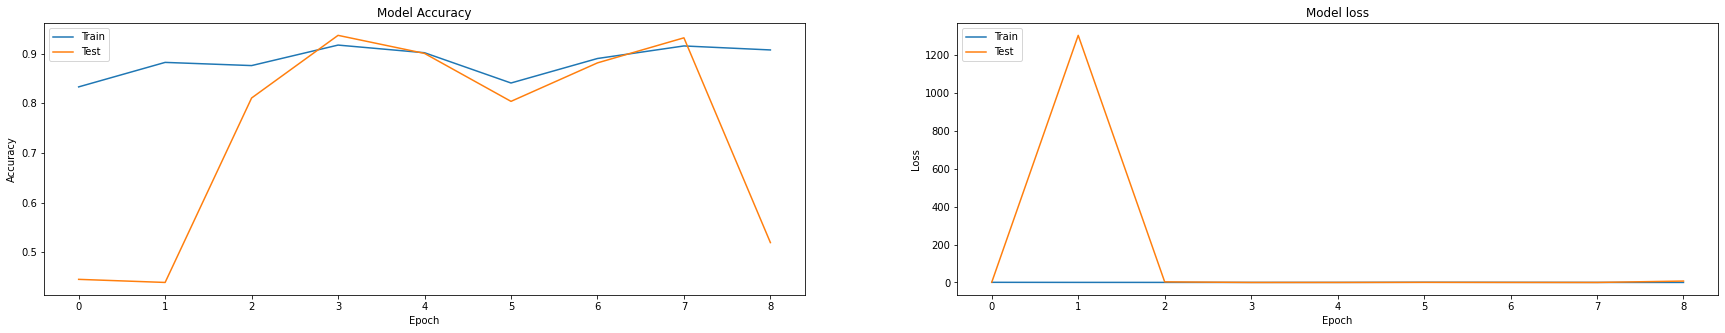

In [14]:
# Plot training & validation acc values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(model4.history.history['accuracy'])
plt.plot(model4.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(model4.history.history['loss'])
plt.plot(model4.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [22]:
# Accuracy on test dataset

test_generator = datagen.flow_from_directory(
    "/OCT2017 /test",
    target_size = (224, 224),
    batch_size=128,
    class_mode = "categorical",
    shuffle = False)
test_samples = 968
batch_size = 128

result = model4.evaluate(test_generator, steps = test_samples // batch_size+1, verbose = 1)
print("Accuracy on Test Dataset:{0}, Loss on Test Dataset: {1}".format(result[1]*100,result[0]))

Found 968 images belonging to 4 classes.
8/8 [==============================] - 13s 1s/step - loss: 0.1236 - accuracy: 0.9618
Accuracy on Test Dataset:96.1776852607727, Loss on Test Dataset: 0.12363702803850174


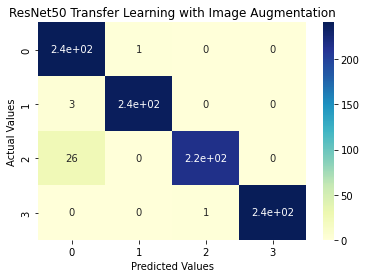

In [24]:
# Plot Confusion Matrix

# predicted values
y_pred = model4.predict(test_generator, test_samples // batch_size+1)
predicted_values = np.argmax(y_pred, axis=1)

confusionmatrix = confusion_matrix(test_generator.classes,predicted_values)
plt.title("ResNet50 Transfer Learning with Image Augmentation")
sns.heatmap(confusionmatrix, annot=True, cmap="YlGnBu")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

**Observations**

We are getting an accuracy of 0.96 on the test dataset using ResNet50 Transfer Learning Model with Image Augmentation.